In [1]:
import os
import xarray as xr
import warnings
import matplotlib.pyplot as plt
import numpy as np
import xgcm
import scipy
#import sentinelhub
import rasterio
from rasterio.merge import merge

warnings.filterwarnings("ignore")
rgb_path = '/work/users/jn906hluu/S2_Frankenwald_daily_HD/2020-08-09'
cm_path = '/work/users/jn906hluu/S2_Frankenwald_daily_HD_CM/2020-08-09'




# list of dataarrays

dataarrays_rgb = [rasterio.open(f'{os.path.join(folder)}/response.tiff') for folder in os.scandir(rgb_path) if os.path.isdir(folder)]
dataarrays_cm = [rasterio.open(f'{os.path.join(folder)}/response.tiff') for folder in os.scandir(cm_path) if os.path.isdir(folder)]

merged_rgb = merge(dataarrays_rgb)
merged_cm = merge(dataarrays_cm)

In [2]:
len_band, len_lat, len_lon, = merged_rgb[0].shape
_, len_lat_cm, len_lon_cm, = merged_cm[0].shape

bbox = [10.294189,50.307024,11.961365,50.972242]

xrds_rgb = xr.Dataset(
    data_vars = dict(
        refl = (['band','lat', 'lon'], merged_rgb[0])
    ),
    coords = dict(
        lat = np.linspace(bbox[3], bbox[1], len_lat),
        lon = np.linspace(bbox[0], bbox[2], len_lon),
        band = np.arange(1, len_band + 1),
    ),
)

xrds_mask = xr.Dataset(
    data_vars = dict(
        mask = (['lat', 'lon'], merged_cm[0][0 , : ,:] / 255)
    ),
    coords = dict(
        lat = np.linspace(bbox[3], bbox[1], len_lat_cm),
        lon = np.linspace(bbox[0], bbox[2], len_lon_cm),
    ),
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


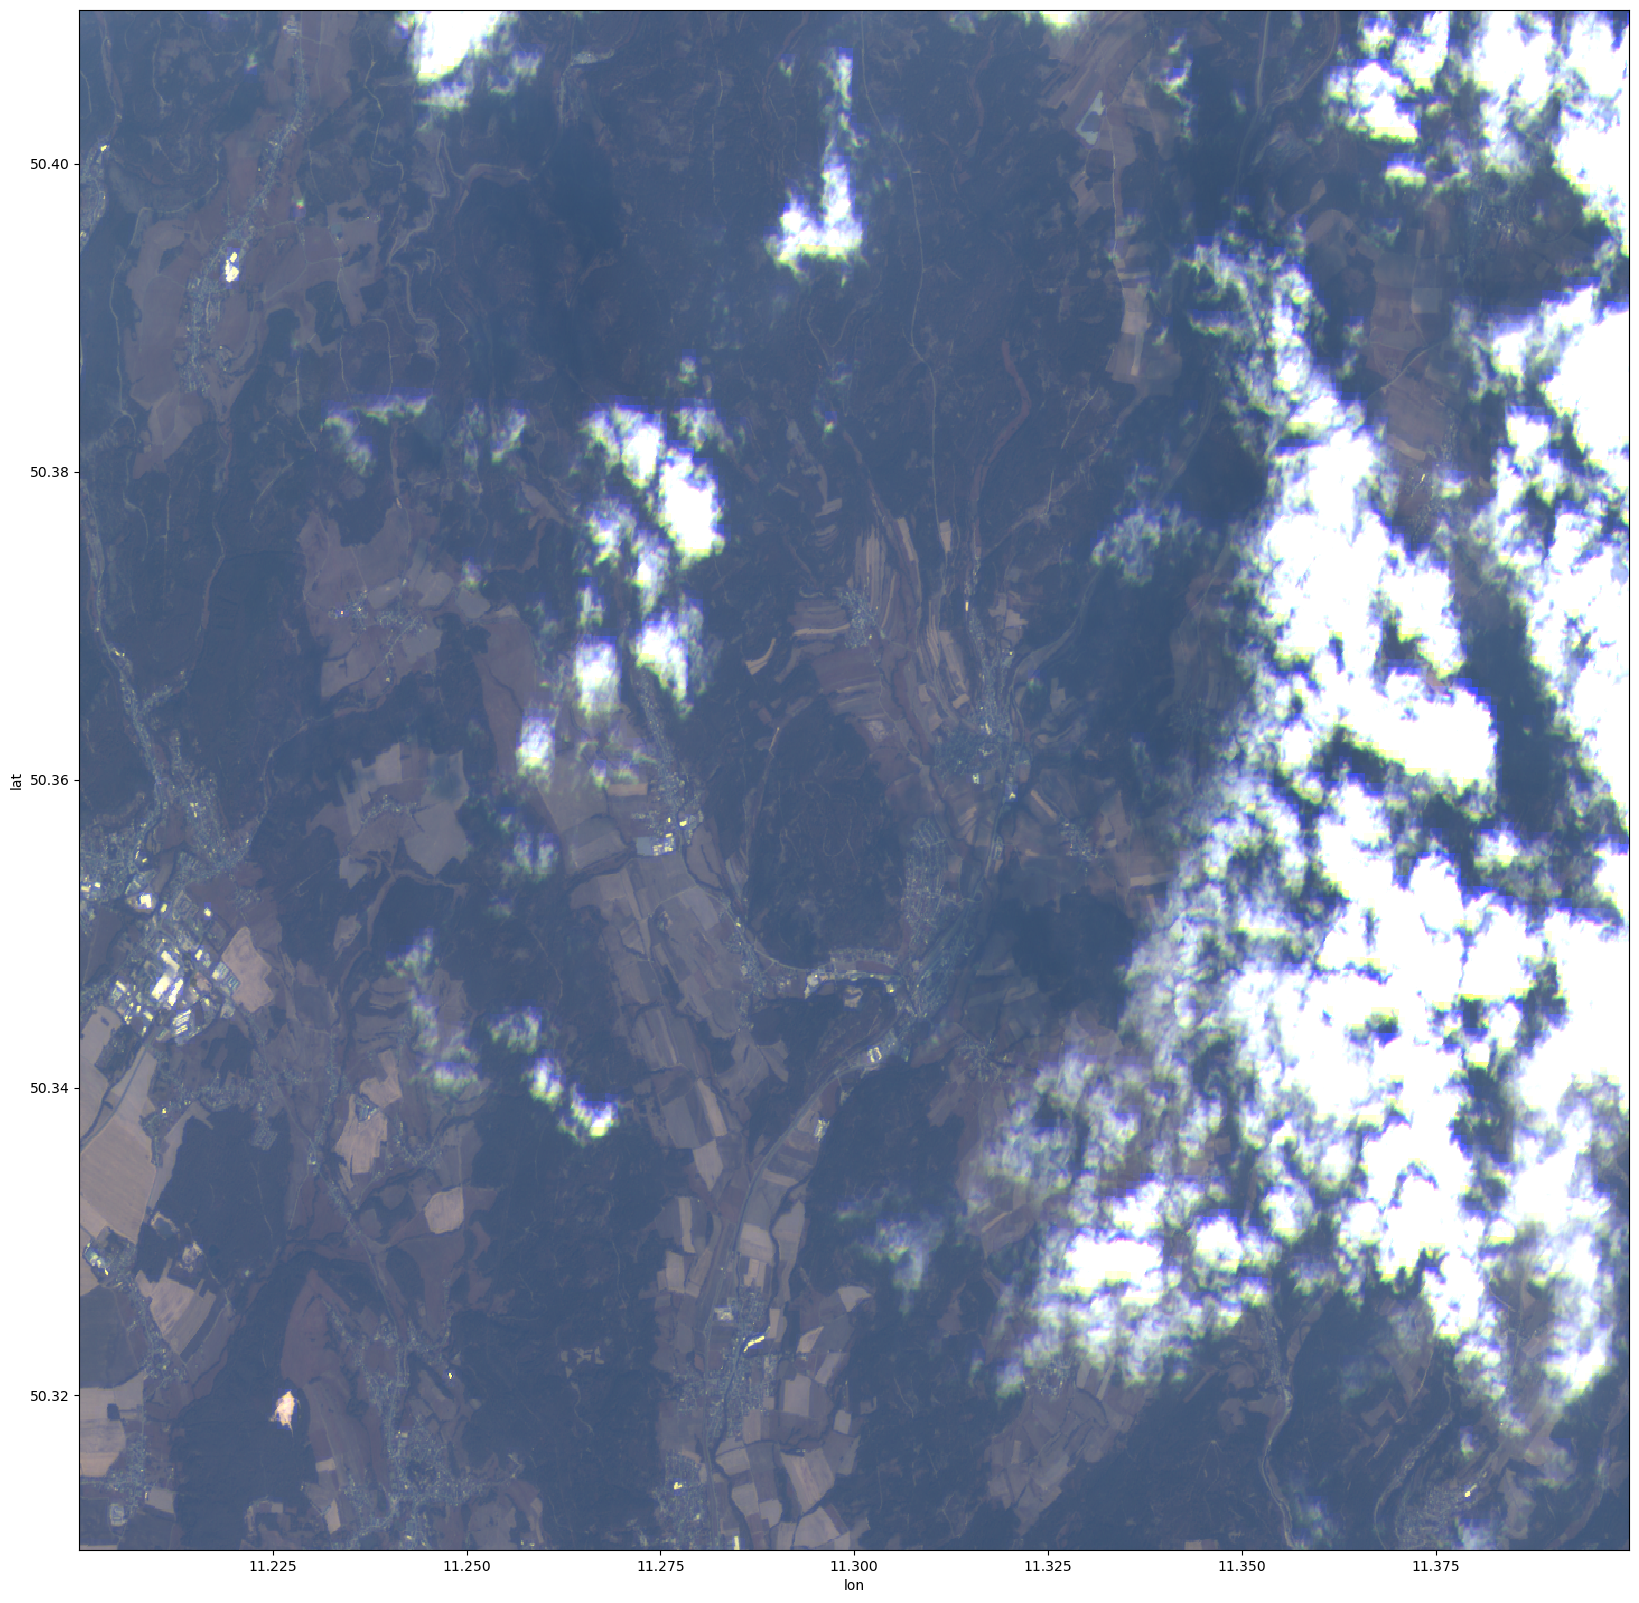

In [3]:
fig, axs = plt.subplots(figsize=(20,20))

xrds = xrds_rgb

(xrds.sel(band=[3,2,1]).sel(lon=slice(11.2, 11.4), lat=slice(50.41, 50.31)).refl / 1e4 * 3.5).plot.imshow(ax=axs)
#(xrds.sel(band=[3,2,1]).sel(lon=slice(10.8, 11.0), lat=slice(50.6, 50.5)).refl / 1e4 * 3.5).plot.imshow(ax=axs[2])

#(xrds.sel(band=[3,2,1]).refl / 1e4 * 3.5).plot.imshow(ax=axs[0])
#axs[0].add_patch(rect1)
#axs[0].add_patch(rect2)

In [9]:
len_lat, len_lon

(7530, 11540)

In [10]:
new_lat = np.linspace(bbox[3], bbox[1], 7530)
new_lon = np.linspace(bbox[0], bbox[2], 11540)

xrds_rgb = xrds_rgb.interp(lat=new_lat, lon=new_lon)

xrds_rgb['mask'] = xrds_mask.interp(lat=new_lat, lon=new_lon).mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


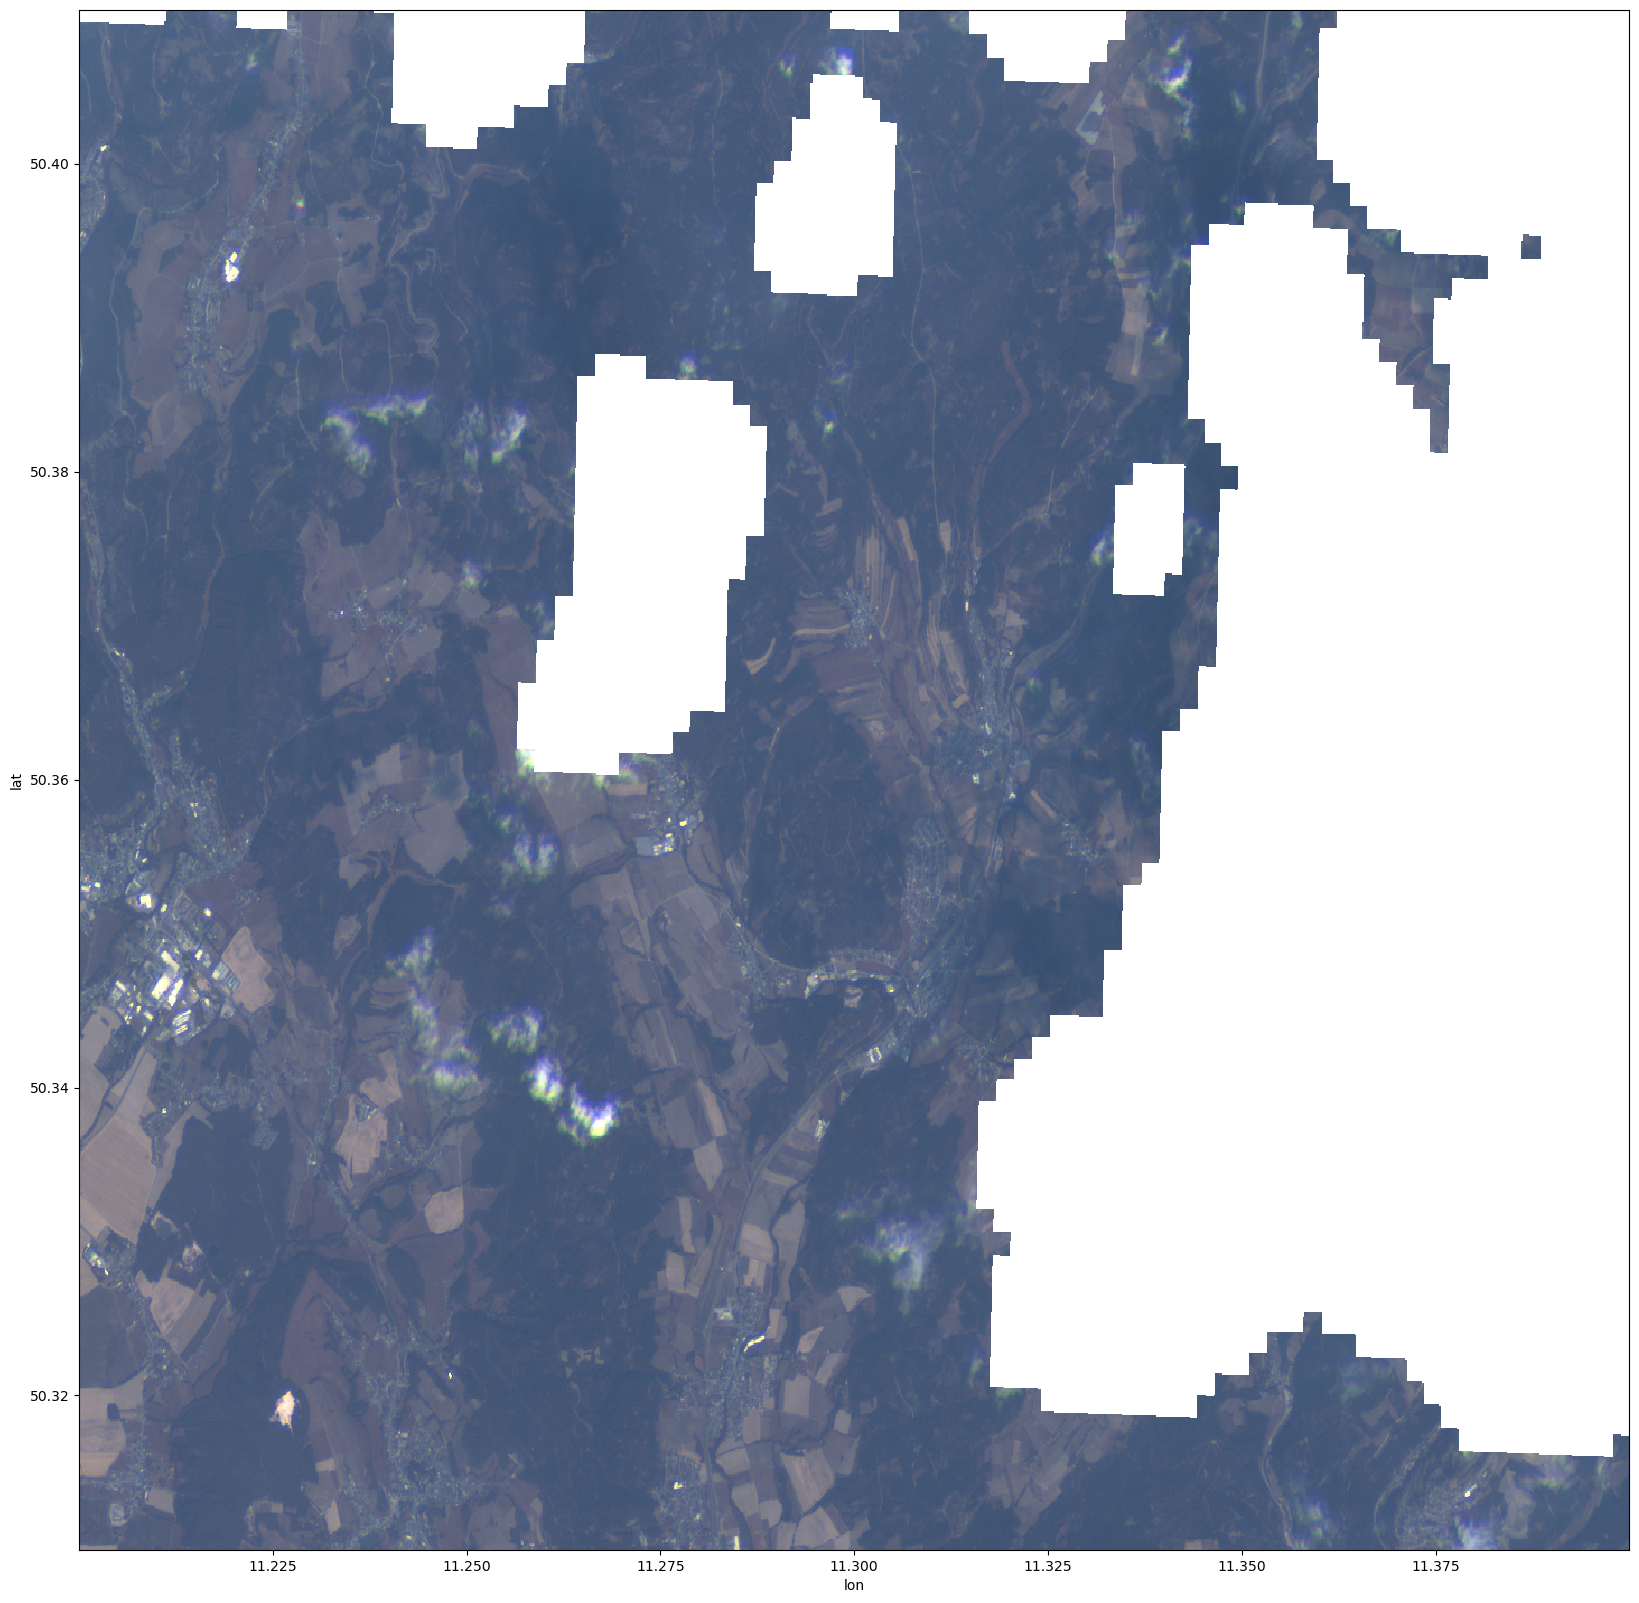

In [7]:
fig, axs = plt.subplots(figsize=(20,20))

xrds_slice = xrds_rgb.sel(band=[3,2,1]).sel(lon=slice(11.2, 11.4), lat=slice(50.41, 50.31))

(xrds_slice.refl.where(xrds_slice.mask < 1) / 1e4 * 3.5).plot.imshow(ax=axs)


In [8]:
xrds_rgb.sel(band=5)

<xarray.Dataset>
Dimensions:  (lat: 7530, lon: 11540)
Coordinates:
  * lat      (lat) float64 50.97 50.97 50.97 50.97 ... 50.31 50.31 50.31 50.31
  * lon      (lon) float64 10.29 10.29 10.29 10.29 ... 11.96 11.96 11.96 11.96
    band     int64 5
Data variables:
    refl     (lat, lon) int16 843 777 777 858 858 ... 963 1115 1115 1241 1241
    mask     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [ ]:
#import rioxarray
#rename_dims = {'lat': 'y', 'lon': 'x'}

# Rename the dimensions using the `rename` method
#dsi = dsi.rename(rename_dims)
#dsi.rio.to_raster("/work/users/jn906hluu/example.tif")

In [11]:
shape_file_path = '/work/users/jn906hluu/RSP/ForestCoverPatternStudy/Layers/D48/D48.shp'

import rasterio
import geopandas as gpd
from rasterio.features import geometry_mask

shapefile = gpd.read_file(shape_file_path)


image_path = '/work/users/jn906hluu/S2_Frankenwald_daily/2019_03_17/response.tiff'
crs_path = '/work/users/jn906hluu/example.tif'

# Open the raster file
with rasterio.open(image_path) as src2:
    with rasterio.open(crs_path) as src:

        # Get the CRS of the raster file
        raster_crs = src2.crs
        # Get the shape of the raster file
        raster_shape = dsi.mask.shape

        shapefile = shapefile.to_crs(raster_crs)
        # Get the transform of the raster file
        raster_transform = src.transform
        geometry = shapefile.geometry
        # Create a mask from the geometry
        mask_tw = geometry_mask([geometry[0]], raster_shape, raster_transform, invert=True)
        mask_fw = geometry_mask([geometry[1]], raster_shape, raster_transform, invert=True)
        mask_all = ~mask_fw & ~mask_tw

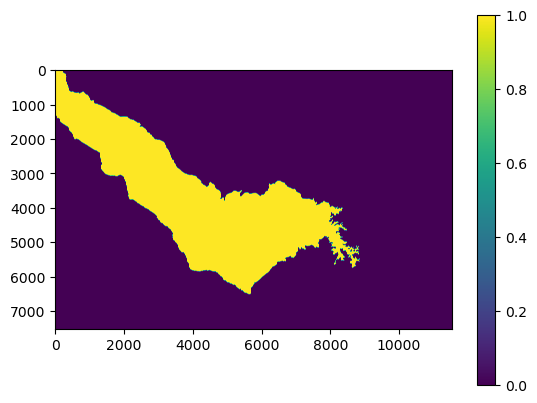

In [12]:
plt.imshow(mask_tw)
plt.colorbar()

In [13]:
boolean_cloud_mask = dsi.mask.astype('bool')

In [15]:
xrds_rgb['mask'] = ~(mask_all | boolean_cloud_mask)

In [18]:
os.listdir('/work/users/jn906hluu/S2_Frankenwald_daily_HD')[0]

'2021-01-03'

In [19]:
xr.open_zarr('/work/users/jn906hluu/S2_Frankenwald_nc/2021-01-03.zarr')

ValueError: unrecognized engine zarr must be one of: ['scipy', 'rasterio', 'store']